In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
import math as math

from google.colab import drive

drive.mount('/content/drive')
%cd /content/drive/MyDrive/SMU_MITB_NLP/project/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/SMU_MITB_NLP/project


# Further pre-processing for inventory management

In [7]:
transactions_cleaned = pd.read_pickle("transactions_cleaned.pkl")
transactions_cleaned.head()

,t_dat,customer_id,article_id,price,sales_channel_id,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,index_group_name,section_name,month,day_of_week,week_of_year,unique_products
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,29.99,2,Underwear body,Underwear,Solid,Black,Dark,Ladieswear,Womens Lingerie,9,3,38,14
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,17.99,2,Bra,Underwear,Solid,Light Pink,Dusty Light,Ladieswear,Womens Lingerie,9,3,38,14
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,8.99,2,Sweater,Garment Upper body,Melange,Pink,Medium Dusty,Divided,Divided Selected,9,3,38,110
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,9.99,2,Sweater,Garment Upper body,Melange,Pink,Medium,Ladieswear,Womens Everyday Collection,9,3,38,110
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,9.99,2,Sweater,Garment Upper body,Melange,Dark Green,Dark,Ladieswear,Womens Everyday Collection,9,3,38,110


**Function to extract a sales record by datetime for particular item from a particular column**

In [128]:
def sales_extractor (item, group, df, frequency="weekly"):
  df = df.copy()
  frequency_dict = {'monthly':'M', 'weekly':'W'}
  series = df[df[group] == item].groupby(['t_dat'])['customer_id'].count()
  output_df = series.resample(frequency_dict[frequency]).sum().to_frame()
  output_df.rename(mapper={'customer_id':'sales_count'}, axis="columns", inplace=True)
  return output_df

# Jeremy's code

# Vincent's code

In [129]:
df = sales_extractor('Sweater', 'product_type_name', transactions_cleaned)
df_train = df.iloc[:-6]
df_test = df.iloc[-6:]

**Using the ARIMA model to predict weekly sales of a particular product**

In [62]:
from sklearn.metrics import mean_squared_error

In [130]:
### Conduct Grid Search for ARIMA ###
def evaluate_arima_model(order):
    model = ARIMA(df_train, order=order)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(df_train), end=len(df_train)+len(df_test)-1, dynamic=False)
    error = mean_squared_error(df_test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [ ]:
# specify range of parameters you want to test
p_values = [0, 1, 2]
d_values = range(0, 3)
q_values = range(0, 3)

# find the best parameters
evaluate_models(p_values, d_values, q_values)

In [131]:
ARIMA_model = ARIMA(df_train, order=(0, 0, 2))
ARIMA_model_fit = ARIMA_model.fit()
print(ARIMA_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            sales_count   No. Observations:                  100
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -1109.864
Date:                Thu, 08 Jun 2023   AIC                           2227.727
Time:                        18:06:14   BIC                           2238.148
Sample:                    09-23-2018   HQIC                          2231.945
                         - 08-16-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.639e+04   4623.626      5.708      0.000    1.73e+04    3.55e+04
ma.L1          0.5732      0.124      4.632      0.000       0.331       0.816
ma.L2          0.3281      0.105      3.132      0.0

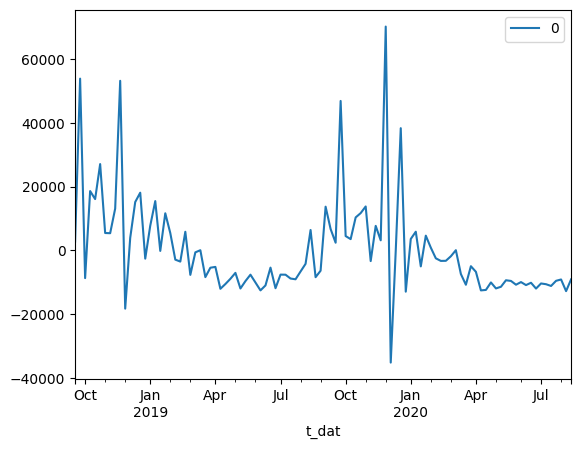

In [132]:
# Plot residual errors for the best ARIMA model
best_residuals = pd.DataFrame(ARIMA_model_fit.resid)
best_residuals.plot()
plt.show()

In [134]:
ARIMA_forecast = ARIMA_model_fit.forecast(steps=6)

<Axes: xlabel='t_dat'>

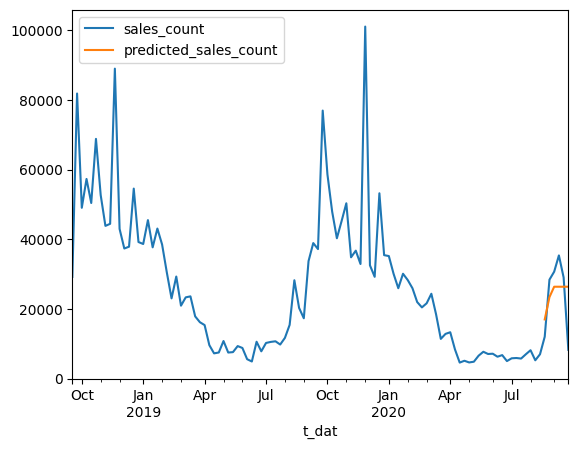

In [180]:
ARIMA_projections = pd.merge(df_test, ARIMA_forecast, left_index=True, right_index=True)
ARIMA_projections.rename(mapper={'predicted_mean':'predicted_sales_count'}, axis="columns", inplace=True)
pd.concat([df_train, ARIMA_projections], axis=0).plot() #Just plot the concatnated df, showing historical and forecasted

In [181]:
### We use RMSE as an objective measure of the accuracy of the forecast ###
ARIMA_mse = mean_squared_error(df_test, ARIMA_forecast)
ARIMA_rmse = sqrt(ARIMA_mse)
print(f"The RMSE for the ARIMA model for the projection of 4 weeks is {ARIMA_rmse}")

The RMSE for the ARIMA model for the projection of 4 weeks is 8974.770017593499


**Next, lets try using the LSTM model to predict sales**

In [137]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

In [174]:
# Since LSTMs are sensitive to the scale of input data, we rescale everything between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
df_train_scaled = scaler.fit_transform(df_train)

# Transform data to be suitable for LSTM input
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Reshape into X=t and Y=t+1
look_back = 4
trainX, trainY = create_dataset(df_train_scaled, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

In [ ]:
# Build and train the LSTM model
LSTM_model = Sequential()
LSTM_model.add(LSTM(4, input_shape=(1, look_back)))
LSTM_model.add(Dense(1))
LSTM_model.compile(loss='mean_squared_error', optimizer='adam')
LSTM_model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

In [176]:
n_future = 7 #Forecast the next 5 data points
forecast_period_dates = pd.date_range(list(df_train.index)[-1], periods=n_future, freq='W').tolist()

forecast = LSTM_model.predict(trainX[-n_future:]) # forecast 

# Perform inverse transformation to rescale back to original range
forecast_copies = np.repeat(forecast, df_train.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]

# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'sales_count':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

1/1 [==============================] - 0s 485ms/step


In [177]:
df_forecast[1:]

,Date,sales_count
1,2020-08-23,6342.298828
2,2020-08-30,6037.364258
3,2020-09-06,5987.191895
4,2020-09-13,5803.742676
5,2020-09-20,6224.002441
6,2020-09-27,6784.600586


In [178]:
df_test

,sales_count
t_dat,
2020-08-23,12056
2020-08-30,28415
2020-09-06,30709
2020-09-13,35372
2020-09-20,29054
2020-09-27,8298


In [179]:
### We use RMSE as an objective measure of the accuracy of the forecast ###
LSTM_mse = mean_squared_error(df_test['sales_count'], df_forecast[1:]['sales_count'])
LSTM_rmse = sqrt(LSTM_mse)
print(f"The RMSE for the LSTM model for the projection of 4 weeks is {LSTM_rmse}")

The RMSE for the LSTM model for the projection of 4 weeks is 20584.596854599116


**Finally, we try tabular transformer**